In [39]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt

# K - Nearest Neighbors

### Definition of distances

In [40]:
# various distances

def euclidian_dist(v1, v2):
    # if a triangle is drawn with the 2 points as corners then the euclidian distance is the hypothenuse
    return np.sqrt(np.sum([np.square(s - x) for x,s in zip(v1, v2)]))

def manhattan_dist(v1, v2):
    # this distance is equal to moving across a grid of squares from point a to point b (no diagonal)
    return np.sum([abs(s - x) for x,s in zip(v1,v2)])

def minkowski_dist(v1, v2, p=3):
    # if p = 1 then it is equivalent to the manhattan distance
    # if p = 2 then it is equivalent to the euclidian distance
    return np.power(np.sum([np.power((s - x), p) for x,s in zip(v1, v2)]), 1/p)


def chebyshev_dist(v1, v2):
    # choses the maximal difference between 2 variables of the 2 vectors 
    # visually it choses the side of the triangle that is longer and not the hypothenuse
    return np.max([abs(s - x) for x,s in zip(v1,v2)])

def cosine_distance(v1, v2):
    # uses the angle of the vectors to determine whether they point in a similar direction
    # norm(v1) == np.sqrt(np.dot(v1,v1)) using (from numpy.linalg import norm)
    return np.dot(v1, v2) / ( np.sqrt(np.dot(v1,v1)) * np.sqrt(np.dot(v2,v2)))

def jaccard_distance(v1, v2):
    # also works well for categorical variables
    anb = len(set(v1).intersection(set(v2)))
    aub = len(set(v1).union(set(v2)))
    return 1 - (anb / aub)

def hamming_distance(v1, v2):
    # the number of substitutions needed to change one string into another
    # also works well for categorical variables or binary strings such as one hot encoding
    if len(v1) != len(v2):
        raise ValueError("For the Hamming distance the 2 vectors must have the same length. Please check this.")
    return np.sum([s != x for x,s in zip(v1,v2)])


### Definition of KNN class

In [41]:
class KNN:
    def __init__(self, knearest=3, distance="euclidian"):
        #Note to self, the instance variable does not need an underscore here, only in the setter and getter
        self.knearest = knearest
        self.distance = distance

    @property
    def distance(self):
        return self._distance
    
    @distance.setter
    def distance(self, distance):
        if distance not in ["euclidian", "manhattan", "minkowski", "chebyshev", "cosine", "hamming", "jaccard"]:
            raise ValueError("Please choose one of the following distance measures: euclidian, manhattan, minkowski, chebyshev, cosine, hamming or jaccard.")
        self._distance = distance

    @property
    def knearest(self):
        return self._knearest
    
    @knearest.setter
    def knearest(self, knearest):
        if not isinstance(knearest,int):
            raise ValueError("Please enter a whole number.")
        elif knearest <= 0:
            raise ValueError("Please enter a number larger than 0.")
        self._knearest = knearest


    def fit(self, X, y):
        self.X_train = X
        self.y_train = y


    def predict(self, samples):
        predicted_labels = [self._predict(x) for x in samples]
        return np.array(predicted_labels)
        
    def _predict(self, sample):
        # compute the distances between the sample the training data
        # Find the k nearest neighbors
        # Chose the label according to majority vote

        #idea limit the points you compute the distance for to sample_var +/- std or variance
        distances = self.compute_dist(sample)
        k_nearest_idx = self._get_k_nearest(distances)
        label = self._get_majority_label(k_nearest_idx)
        return label
    
    def compute_dist(self, sample):
        distances = {}
        match self.distance:
            case "euclidian":
                return [euclidian_dist(x, sample) for x in self.X_train]
            case  "manhattan" :
                return [manhattan_dist(x, sample) for x in self.X_train]
            case "minkowski" :
                return [minkowski_dist(x, sample) for x in self.X_train]
            case "chebyshev":
                return [chebyshev_dist(x, sample) for x in self.X_train]
            case "cosine":
                return [cosine_distance(x, sample) for x in self.X_train]
            case "hamming":
                return [hamming_distance(x, sample) for x in self.X_train]
            case "jaccard":
                return [jaccard_distance(x, sample) for x in self.X_train]
        
    
    def _get_k_nearest(self, distances):
        sorted_neighbors = np.argsort(distances)
        return sorted_neighbors[:self.knearest]
    
    def _get_majority_label(self, k_nearest_idx):
        labels = []
        for neighbor in k_nearest_idx:
            labels.append(self.y_train[neighbor])
        return collections.Counter(labels).most_common()[0][0]

### Some basic performance metrics

In [42]:
def mean_absolute_error(predicted, target):
    return (np.sum([abs(t-p) for t,p in zip(predicted, target)])/len(predicted))

def accuracy(predicted, target):
    return np.sum(predicted == target) / len(target)

### Test on iris data set

In [43]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

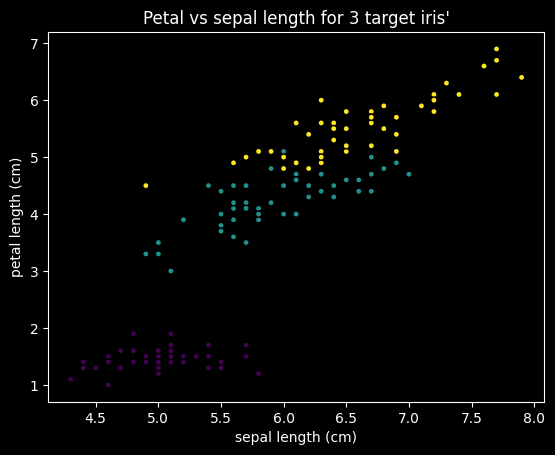

In [44]:
plt.figure()
plt.title("Petal vs sepal length for 3 target iris'")
plt.scatter(X[:,0], X[:,2], c=y, edgecolors='k', s=20)
plt.ylabel(iris.feature_names[2])
plt.xlabel(iris.feature_names[0])
plt.show()

In [51]:
model = KNN(3, distance="manhattan")
model.fit(X_train, y_train)
predicted = model.predict(X_test)

print("Mean absolute error: ", mean_absolute_error(predicted, y_test))
print("Accuracy: ", accuracy(predicted, y_test))

Mean absolute error:  0.022222222222222223
Accuracy:  0.9777777777777777
